Global imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

Different options for datasets

In [2]:
mnist = keras.datasets.mnist                                              # 28x28, handwritten digits 0-9
fashion_mnist = keras.datasets.fashion_mnist                              # 28x28, fashion article images of 10 different classes
cifar10 = keras.datasets.cifar10                                          # 32x32, RGB images of 10 different classes
handsign = ("data/sign_mnist_train.csv", "data/sign_mnist_test.csv")      # 28x28, greyscale images of handsigns, 24 letters / classes

Pivotal Parameters

In [3]:
dataset = mnist
ratio_D1_D2 = 20
ratio_test_val = 6
latent_vector_size = 8

lr_autoencoder = 0.001
loss_autoencoder = "mse"
optimizer_autoencoder = "adam"
epochs_autoencoder = 6

lr_classifier = 0.005
loss_classifier = "categorical_crossentropy"
optimizer_classifier = "adam"
epochs_classifier = 20
freeze_encoder = False

n_autoencoder_reconstructions = 16
show_tsne = True

In [4]:
if dataset == "handsign":
    train_data = pd.read_csv(handsign[0])
    test_data = pd.read_csv(handsign[1])
    x_train = train_data.drop("label", axis=1).to_numpy().reshape((len(train_data), 28, 28))
    y_train = train_data[["label"]].to_numpy()
    x_test = test_data.drop("label", axis=1).to_numpy().reshape((len(test_data), 28, 28))
    y_test = test_data[["label"]].to_numpy()
else:
    (x_train, y_train), (x_test, y_test) = dataset.load_data()

In [5]:
from utils.normalize import normalize

image_shape = x_train.shape[1:3]

x_train = x_train[:len(x_train) // 5]
y_train = y_train[:len(y_train) // 5]
# x_test = x_test[:len(x_test) // 8]
# y_test = y_test[:len(y_test) // 8]

if len(x_train.shape) == 4:
    # if RGB images, convert to grayscale according to the luminosity formula
    x_train = np.average(x_train, axis=-1, weights=[0.21, 0.72, 0.07]).reshape(x_train.shape[:-1])
    x_test = np.average(x_test, axis=-1, weights=[0.21, 0.72, 0.07]).reshape(x_test.shape[:-1])


x_train = normalize(x_train)
x_test = normalize(x_test)

print("Shape of training data:    ", x_train.shape)
print("Shape of training targets: ", y_train.shape)

Shape of training data:     (12000, 28, 28)
Shape of training targets:  (12000,)


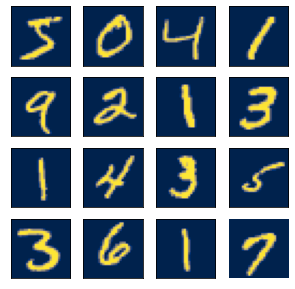

In [6]:
from utils.visualize import show_image_chunk
show_image_chunk(x_train[:16])

Size training set D1:     11428
Size training set D2:     572 

Size test set:            8571
Size validation set:      1429
----------------------------------------------------
Distribution of classes in each training dataset:



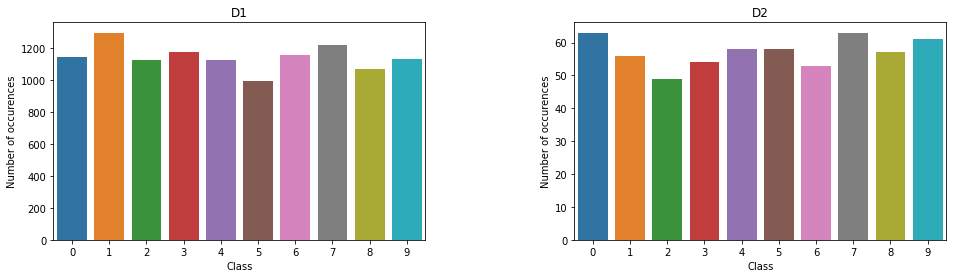

In [7]:
# divide data into D1 and D2. Test data will still be the same
from utils.data import split_data_sets
from utils.visualize import plot_distributions

fraq_D1 = ratio_D1_D2 / (ratio_D1_D2 + 1)
(x_train_d1, y_train_d1), (x_train_d2, y_train_d2) = split_data_sets(fraq_D1, x_train, y_train)
fraq_test_val = ratio_test_val  / (ratio_test_val + 1)
(x_test, y_test), (x_val, y_val) = split_data_sets(fraq_test_val, x_test, y_test)

print("Size training set D1:    ", len(x_train_d1))
print("Size training set D2:    ", len(x_train_d2), "\n")
print("Size test set:           ", len(x_test))
print("Size validation set:     ", len(x_val))
print("-"*52)
print("Distribution of classes in each training dataset:\n")
plot_distributions([y_train_d1, y_train_d2], ["D1", "D2"])

In [8]:
# one hot encoding of categories
from tensorflow.keras.utils import to_categorical

y_train_d1 = to_categorical(y_train_d1)
y_train_d2 = to_categorical(y_train_d2)

test_labels = y_test                                  # save numerical format for later
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [9]:
from models.encoder import deep_conv_encoder
from models.decoder import deep_conv_decoder

encoder = deep_conv_encoder(image_shape, latent_vector_size)
decoder = deep_conv_decoder(latent_vector_size, image_shape)

def deep_autoencoder(encoder, decoder):
    input_layer = tf.keras.Input(shape=encoder.input_shape[1:], name="input img")
    encoded = encoder(input_layer)
    decoded = decoder(encoded)
    return tf.keras.Model(input_layer, decoded, name="autoencoder")

autoencoder = deep_autoencoder(encoder, decoder)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input img (InputLayer)       [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8)                 887310    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         890753    
Total params: 1,778,063
Trainable params: 1,778,063
Non-trainable params: 0
_________________________________________________________________


In [10]:
from models.classifier import deep_classifier
n_classes = 25 if dataset == "handsign" else 10

classifier_C1 = deep_classifier(n_classes, encoder=encoder)
classifier_C2 = deep_classifier(n_classes, latent_vector_size=latent_vector_size, input_shape=image_shape)
print("C1:")
print(classifier_C1.summary())
print("\nC2:")
print(classifier_C2.summary())

C1:
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8)                 887310    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                90        
Total params: 887,400
Trainable params: 887,400
Non-trainable params: 0
_________________________________________________________________
None

C2:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 4)         40        
________________________

In [11]:
from utils.callback import TrainingCallback
from utils.optimizer import optimizer

logs_autoencoder = []
autoencoder.compile(optimizer=optimizer(optimizer_autoencoder, lr_autoencoder), loss=loss_autoencoder)
initial_compressed_images = encoder.predict(x_test)
autoencoder.fit(x_train_d1, x_train_d1, epochs=epochs_autoencoder, batch_size=64, validation_data=(x_val, x_val), verbose=1, callbacks=[TrainingCallback(logs_autoencoder)])


Epoch 1/6
179/179 [==============================] - 6s 33ms/step - loss: 0.0641 - val_loss: 0.0343
Epoch 2/6
179/179 [==============================] - 5s 28ms/step - loss: 0.0335 - val_loss: 0.0298
Epoch 3/6
179/179 [==============================] - 5s 27ms/step - loss: 0.0296 - val_loss: 0.0277
Epoch 4/6
179/179 [==============================] - 5s 28ms/step - loss: 0.0275 - val_loss: 0.0263
Epoch 5/6
179/179 [==============================] - 5s 27ms/step - loss: 0.0265 - val_loss: 0.0257
Epoch 6/6
179/179 [==============================] - 5s 27ms/step - loss: 0.0254 - val_loss: 0.0250


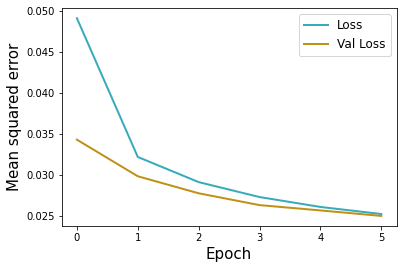

In [12]:
from utils.visualize import plot_logs
plot_logs("Autoencoder training", [logs_autoencoder], "loss", ["Loss"], "Mean squared error")

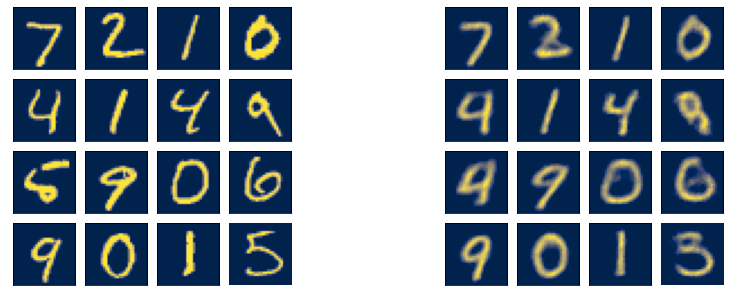

In [13]:
from utils.visualize import show_image_chunks
transformed_images = autoencoder.predict(x_test)  # .reshape((len(x_test), ) + image_shape)

show_image_chunks([x_test[:n_autoencoder_reconstructions], transformed_images[:n_autoencoder_reconstructions]])
#show_image_chunk(x_test[:16])
#show_image_chunk(transformed_images[:16])


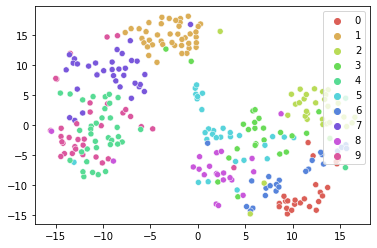

In [14]:
# Now that autoencoder is trained, the encoder module can be used for other things
# encoder = keras.Model(input_layer, latent_layer)
from utils.visualize import tsne_plot

compressed_images = encoder.predict(x_test)
if show_tsne:
    labels = test_labels[:300]
    if len(labels.shape) == 2:
        labels = labels.reshape((300, ))
    tsne_plot(compressed_images[:300], labels)

In [15]:
if freeze_encoder:
    encoder.trainable = False
print(x_val.shape)
print(y_val.shape)
logs_C1 = []
classifier_C1.compile(optimizer=optimizer(optimizer_classifier, lr_classifier), loss="categorical_crossentropy", metrics=['accuracy'])
classifier_C1.fit(x_train_d2, y_train_d2, epochs=epochs_classifier, batch_size=64, validation_data=(x_val, y_val), verbose=1, callbacks=[TrainingCallback(logs_C1)])
loss_C1, acc_C1 = classifier_C1.evaluate(x_test, y_test)

(1429, 28, 28)
(1429, 10)
Epoch 1/20
9/9 [==============================] - 1s 47ms/step - loss: 2.7469 - accuracy: 0.2293 - val_loss: 1.8678 - val_accuracy: 0.3849
Epoch 2/20
9/9 [==============================] - 0s 29ms/step - loss: 1.7219 - accuracy: 0.4268 - val_loss: 1.3227 - val_accuracy: 0.5304
Epoch 3/20
9/9 [==============================] - 0s 28ms/step - loss: 1.0815 - accuracy: 0.6597 - val_loss: 0.8986 - val_accuracy: 0.6760
Epoch 4/20
9/9 [==============================] - 0s 28ms/step - loss: 0.5785 - accuracy: 0.8043 - val_loss: 0.6251 - val_accuracy: 0.8286
Epoch 5/20
9/9 [==============================] - 0s 29ms/step - loss: 0.3134 - accuracy: 0.9142 - val_loss: 0.6065 - val_accuracy: 0.8314
Epoch 6/20
9/9 [==============================] - 0s 29ms/step - loss: 0.1824 - accuracy: 0.9572 - val_loss: 0.4522 - val_accuracy: 0.8775
Epoch 7/20
9/9 [==============================] - 0s 29ms/step - loss: 0.1036 - accuracy: 0.9570 - val_loss: 0.4914 - val_accuracy: 0.8761
E

In [16]:
logs_C2 = []

classifier_C2.compile(optimizer=optimizer(optimizer_classifier, lr_classifier), loss=loss_classifier, metrics=['accuracy'])
classifier_C2.fit(x_train_d2, y_train_d2, epochs=epochs_classifier, batch_size=64, validation_data=(x_val, y_val), verbose=1, callbacks=[TrainingCallback(logs_C2)])
loss_C2, acc_C2 = classifier_C2.evaluate(x_test, y_test)

Epoch 1/20
9/9 [==============================] - 1s 47ms/step - loss: 2.2518 - accuracy: 0.1593 - val_loss: 1.7659 - val_accuracy: 0.3597
Epoch 2/20
9/9 [==============================] - 0s 27ms/step - loss: 1.5076 - accuracy: 0.4248 - val_loss: 1.3839 - val_accuracy: 0.5220
Epoch 3/20
9/9 [==============================] - 0s 26ms/step - loss: 0.9945 - accuracy: 0.6093 - val_loss: 1.1270 - val_accuracy: 0.5675
Epoch 4/20
9/9 [==============================] - 0s 28ms/step - loss: 0.7293 - accuracy: 0.6887 - val_loss: 0.9295 - val_accuracy: 0.6466
Epoch 5/20
9/9 [==============================] - 0s 28ms/step - loss: 0.5345 - accuracy: 0.8184 - val_loss: 0.9003 - val_accuracy: 0.7474
Epoch 6/20
9/9 [==============================] - 0s 27ms/step - loss: 0.2910 - accuracy: 0.8765 - val_loss: 0.8390 - val_accuracy: 0.7782
Epoch 7/20
9/9 [==============================] - 0s 28ms/step - loss: 0.2417 - accuracy: 0.9034 - val_loss: 0.9355 - val_accuracy: 0.8167
Epoch 8/20
9/9 [===========

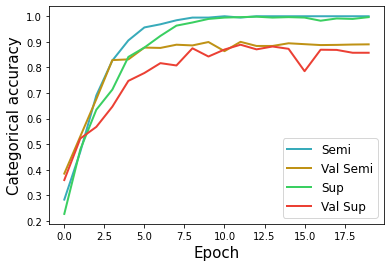

In [17]:
plot_logs("Accuracy", [logs_C1, logs_C2], "accuracy", ["Semi", "Sup"], "Categorical accuracy")

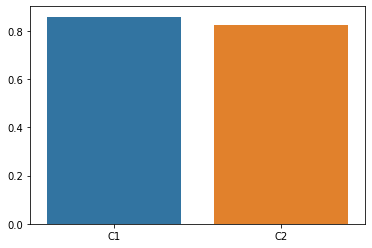

In [18]:
from utils.visualize import compare_accuracy
compare_accuracy([acc_C1, acc_C2], ["C1", "C2"])

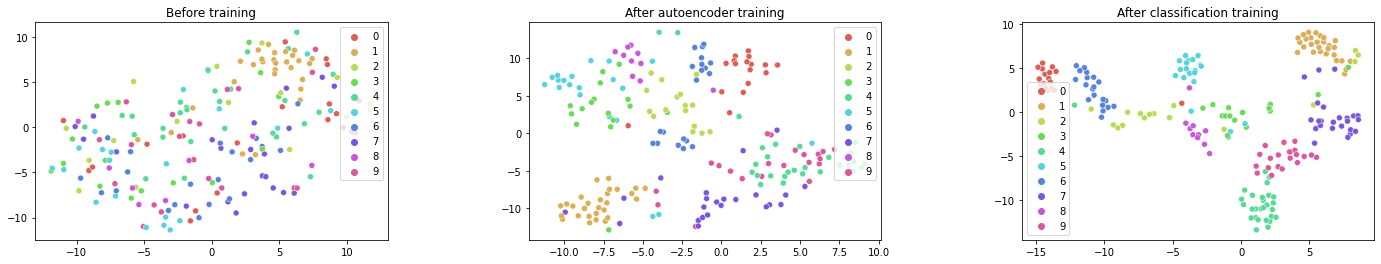

In [19]:
from utils.visualize import tsne_plots

compressed_images_after_classification = encoder.predict(x_test)
if show_tsne:
    labels = test_labels[:200]
    if len(labels.shape) == 2:
        labels = labels.reshape((200, ))
    tsne_plots([initial_compressed_images[:200], compressed_images[:200], compressed_images_after_classification[:200]], 
              ["Before training", "After autoencoder training", "After classification training"], 
              labels)